In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/elo-merchant-category-recommendation/Data_Dictionary.xlsx
/kaggle/input/elo-merchant-category-recommendation/Data Dictionary.xlsx
/kaggle/input/elo-merchant-category-recommendation/historical_transactions.csv
/kaggle/input/elo-merchant-category-recommendation/merchants.csv
/kaggle/input/elo-merchant-category-recommendation/train.csv
/kaggle/input/elo-merchant-category-recommendation/new_merchant_transactions.csv
/kaggle/input/elo-merchant-category-recommendation/test.csv
/kaggle/input/elo-merchant-category-recommendation/sample_submission.csv
/kaggle/input/elodmbiproject/td01_1.csv
/kaggle/input/elodmbiproject/agg_transactions.csv
/kaggle/input/elodmbiproject/hmd01_1.csv


# Sampling
Code to generate samples from training data. (td_<ratio>.csv)
All transactions related to the cards_id in the samples would be extracted from historical_transactions.csv and new_merchant_period.csv (hmd_<ratio>.csv)
    
Note: This sampling is only for the purposes of finalizing the workflow and for testing purposes as the time to run these for the entire dataset is high.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import DataFrame as df

# train_data = pd.read_csv('../input/elo-merchant-category-recommendation/train.csv')
# td_card = np.unique(train_data['card_id']) # 201917

# ratio = 0.01
# card_num = int(np.size(td_card, 0) * ratio)
# sampled_card = np.random.choice(td_card, card_num)
# del td_card

# samp_c = df(sampled_card,columns=['card_id'])
# del sampled_card

# filter1 = train_data["card_id"].isin(samp_c.card_id.tolist())
# td = train_data[filter1]
# del train_data, filter1

# print("Reading historical_transactions...............")
# historical_data = pd.read_csv('../input/elo-merchant-category-recommendation/historical_transactions.csv')
# filter2 = historical_data["card_id"].isin(samp_c.card_id.tolist())
# hd = historical_data[filter2]
# del historical_data, filter2

# print("Reading new_merchant_transactions...............")
# merchant_data = pd.read_csv('../input/elo-merchant-category-recommendation/new_merchant_transactions.csv')
# filter3 = merchant_data["card_id"].isin(samp_c.card_id.tolist())
# md = merchant_data[filter3]
# del merchant_data, filter3

# frames = [hd, md]
# hmd = pd.concat(frames)
# print(hmd)

# Data Preparation

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import DataFrame as df
import datetime
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


import gc

transaction_data = pd.read_csv('../input/elodmbiproject/hmd01_1.csv',parse_dates=['purchase_date'])


# uncomment the following lines to run the model on the entire dataset
# hist = pd.read_csv('../input/elo-merchant-category-recommendation/historical_transactions.csv', parse_dates=['purchase_date'])
# print(hist.shape)

# new_merch = pd.read_csv('../input/elo-merchant-category-recommendation/new_merchant_transactions.csv', parse_dates=['purchase_date'])
# print(new_merch.shape)


# frames = [hist, new_merch]
# transaction_data = pd.concat(frames)
# print(transaction_data.shape)
# del hist, new_merch
# gc.collect()



#delete inconsistent data
indexNames = transaction_data[ transaction_data['city_id'] == -1].index
transaction_data.drop(indexNames , inplace=True)

indexNames = transaction_data[ transaction_data['category_2'].isna() ].index
transaction_data.drop(indexNames , inplace=True)

indexNames = transaction_data[ transaction_data['installments'] == -1].index
transaction_data.drop(indexNames , inplace=True)

indexNames = transaction_data[ transaction_data['installments'] == 999].index
transaction_data.drop(indexNames , inplace=True)

indexNames = transaction_data[ transaction_data['purchase_amount'] > 1].index
transaction_data.drop(indexNames , inplace=True)


# dropping ALL duplicate values 
transaction_data.drop_duplicates(subset =['card_id','merchant_id','purchase_date' ], keep = 'first', inplace = True) 

transaction_data['subsector_id_copy'] = transaction_data['subsector_id']

#replace other missing values with 0
transaction_data  = transaction_data.fillna(0)

In [4]:
#encoding Y=1, N=0
transactions = transaction_data

transactions['authorized_flag'] = transactions['authorized_flag'].map({'Y':1, 'N':0})
transactions["category_1"] = transactions["category_1"].map({'Y':1, 'N':0})

#one hot encoding
transactions = pd.get_dummies(transactions, columns=['category_2', 'category_3', 'subsector_id'])


transactions['month_diff'] = ((datetime.datetime.today() - transactions['purchase_date']).dt.days)//30
transactions['month_diff'] += transactions['month_lag']

del transaction_data
transactions[:5]


,Unnamed: 0,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,...,subsector_id_33,subsector_id_34,subsector_id_35,subsector_id_36,subsector_id_37,subsector_id_38,subsector_id_39,subsector_id_40,subsector_id_41,month_diff
0,86955,1,C_ID_fa73b85d9f,30,0,3,667,M_ID_392fe845f2,-2,-0.236427,...,0,0,0,0,0,0,0,0,0,30
2,86957,1,C_ID_fa73b85d9f,30,0,1,705,M_ID_acec4d5aa3,-1,-0.641872,...,1,0,0,0,0,0,0,0,0,30
6,86961,1,C_ID_fa73b85d9f,30,0,3,437,M_ID_9a4689c41e,-9,-0.416325,...,0,0,0,0,0,0,0,0,0,31
16,86971,1,C_ID_fa73b85d9f,30,0,2,332,M_ID_442cce57b7,-1,-0.465912,...,0,0,0,0,0,0,0,0,0,30
20,86975,1,C_ID_fa73b85d9f,30,0,5,210,M_ID_bd01e00df0,-7,0.919863,...,0,0,1,0,0,0,0,0,0,30


In [5]:
#joining merchant data

merchants = pd.read_csv('../input/elo-merchant-category-recommendation/merchants.csv')
merchants["category_1"] = merchants["category_1"].map({'Y':1, 'N':0})
merchants["category_4"] = merchants["category_4"].map({'Y':1, 'N':0})
merchants = merchants.rename(columns={"category_1": "mer_category_1", "category_2": "mer_category_2","category_4": "mer_category_4", "city_id":"mer_city_id"})

print("merchants file read ")

#columns selected 
merchant_columns = ["merchant_id", "mer_category_4", "mer_city_id", "merchant_group_id" ]

merchants =merchants[merchant_columns]

transactions = pd.merge(transactions, merchants, on='merchant_id', how='left')

transactions["same_city"]=np.where(transactions['city_id'] == transactions['mer_city_id'] , 1, 0)
del merchants

merchants file read 


Aggregation of data

In [6]:
def aggregate_transactions(data):
    
    data.loc[:, 'purchase_date'] = pd.DatetimeIndex(data['purchase_date']).\
                astype(np.int64) * 1e-9
     
    agg_func = {
    'authorized_flag': ['mean'],
    'category_1': ['mean'],
    'category_2_1.0': ['mean'],
    'category_2_2.0': ['mean'],
    'category_2_3.0': ['mean'],
    'category_2_4.0': ['mean'],
    'category_2_5.0': ['mean'],
    'category_3_A': ['mean'],
    'category_3_B': ['mean'],
    'category_3_C': ['mean'],
    'merchant_id': ['nunique'],
    'merchant_category_id': ['nunique'],
    'merchant_group_id': ['nunique'],

    'mer_category_4': ['mean'],
    
    'state_id': ['nunique'],
    'city_id': ['nunique'],
    'same_city': ['mean'],
        
#       'subsector_id': ['nunique'],  
    'subsector_id_copy': ['nunique'],
    'subsector_id_1':['mean'],
    'subsector_id_2':['mean'],
    'subsector_id_3':['mean'],
    'subsector_id_4':['mean'],
    'subsector_id_5':['mean'],
    'subsector_id_7':['mean'],
    'subsector_id_8':['mean'],
    'subsector_id_9':['mean'],
    'subsector_id_10':['mean'],
    'subsector_id_11':['mean'],
    'subsector_id_12':['mean'],
    'subsector_id_13':['mean'],
    'subsector_id_14':['mean'],
    'subsector_id_15':['mean'],
    'subsector_id_16':['mean'],
    'subsector_id_17':['mean'],
    'subsector_id_18':['mean'],
    'subsector_id_19':['mean'],
    'subsector_id_20':['mean'],
    'subsector_id_21':['mean'],
    'subsector_id_22':['mean'],
    'subsector_id_23':['mean'],
    'subsector_id_24':['mean'],
    'subsector_id_25':['mean'],
    'subsector_id_26':['mean'],
    'subsector_id_27':['mean'],
    'subsector_id_29':['mean'],
    'subsector_id_30':['mean'],
    'subsector_id_31':['mean'],
    'subsector_id_32':['mean'],
    'subsector_id_33':['mean'],
    'subsector_id_34':['mean'],
    'subsector_id_35':['mean'],
    'subsector_id_36':['mean'],
    'subsector_id_37':['mean'],
    'subsector_id_38':['mean'],
    'subsector_id_39':['mean'],
    'subsector_id_40':['mean'],
    'subsector_id_41':['mean'],
    
    'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
    'installments': ['sum', 'mean', 'max', 'min', 'std'],
    'purchase_date': [np.ptp, 'min', 'max'],
    'month_diff': ['mean', 'max', 'min', 'std'],
        
    }
    
    agg_transactions = data.groupby(['card_id']).agg(agg_func)
    
    agg_transactions.columns = ['_'.join(col).strip() for col in agg_transactions.columns.values]
    agg_transactions.reset_index(inplace=True)
    
    temp_df = (data.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_transactions = pd.merge(temp_df, agg_transactions, on='card_id', how='left')
    
    return agg_transactions


agg_transactions = aggregate_transactions(transactions)

# uncomment this line to run the models on the entire dataset 
# agg_transactions = pd.read_csv('../input/elodmbiproject/agg_transactions.csv')

agg_transactions[:5]

del transactions
gc.collect()


#scaling

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


columns_to_scale = [c for c in agg_transactions.columns if c not in ['card_id', 'Unnamed: 0']]

agg_transactions[columns_to_scale ] = scaler.fit_transform(agg_transactions[columns_to_scale])

agg_transactions[:5]

# print("writing to csv.........")
# agg_transactions.to_csv(r'/kaggle/working/agg_transactions.csv')


,card_id,transactions_count,authorized_flag_mean,category_1_mean,category_2_1.0_mean,category_2_2.0_mean,category_2_3.0_mean,category_2_4.0_mean,category_2_5.0_mean,category_3_A_mean,...,installments_max,installments_min,installments_std,purchase_date_ptp,purchase_date_min,purchase_date_max,month_diff_mean,month_diff_max,month_diff_min,month_diff_std
0,C_ID_0017fee682,0.074208,0.987952,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.333333,0.1,0.075230,0.412075,0.583920,0.984827,0.004979,0.076923,0.000000,0.338533
1,C_ID_001b68a34b,0.164706,0.918033,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.250000,0.1,0.036469,0.561320,0.171748,0.692110,0.339159,0.384615,0.333333,0.432566
2,C_ID_00340719cc,0.013575,0.812500,0.0,1.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.416667,0.1,0.258000,0.471418,0.474075,0.929076,0.015496,0.076923,0.000000,0.570088
3,C_ID_0038d26a33,0.046154,0.961538,0.0,1.000000,0.0,0.000000,0.0,0.000000,1.0,...,0.000000,0.0,0.000000,0.783833,0.166961,0.939852,0.014304,0.076923,0.000000,0.540236
4,C_ID_0045c40db7,0.158371,0.977273,0.0,0.977273,0.0,0.011364,0.0,0.011364,1.0,...,0.000000,0.0,0.000000,0.541103,0.248242,0.754944,0.184072,0.230769,0.166667,0.594346


In [7]:
#Join aggregated data with the training data

def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df

train = read_data('../input/elodmbiproject/td01_1.csv')

#uncomment the following line to run on the entire dataset

# train = read_data('../input/elo-merchant-category-recommendation/train.csv')
print("training file read ")

train = pd.merge(train, agg_transactions, on='card_id', how='left')
# train.drop(columns=['Unnamed: 0'])
train[['elapsed_time']] = scaler.fit_transform(train[['elapsed_time']])

train = pd.get_dummies(train, columns=['feature_1', 'feature_2'])

train  = train.fillna(0)

train_split = np.split(train, [int(0.9*train.shape[0])] , axis=0)
train_data = train_split[0]
test_data = train_split[1]



training file read 


In [8]:
#correlations

features = [c for c in train.columns if c not in ['card_id', 'first_active_month', 'Unnamed: 0','target']]

for colm in features:
    print(colm ," :  ", train["target"].corr(train[colm]) )

feature_3  :   -0.016473444582648447
elapsed_time  :   -0.04104811111045266
transactions_count  :   0.0015618645974714738
authorized_flag_mean  :   0.06387889129577622
category_1_mean  :   nan
category_2_1.0_mean  :   -0.01791143470747781
category_2_2.0_mean  :   0.02187225033264071
category_2_3.0_mean  :   0.03798976289143446
category_2_4.0_mean  :   0.006871942298505523
category_2_5.0_mean  :   -0.03131010711018153
category_3_A_mean  :   0.010096660089610923
category_3_B_mean  :   -0.007647678605384358
category_3_C_mean  :   -0.0076608714596933325
merchant_id_nunique  :   -0.016160657050883733
merchant_category_id_nunique  :   -0.016687778659372866
merchant_group_id_nunique  :   -0.014192872074672156
mer_category_4_mean  :   -0.00849747083874738
state_id_nunique  :   -0.037918692016639596
city_id_nunique  :   -0.04627037979499457
same_city_mean  :   -0.025003889671278312
subsector_id_copy_nunique  :   -0.020057492413115822
subsector_id_1_mean  :   0.007065259205909215
subsector_id_2_

# OLS Linear Regression

/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:693: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Rsq 0.06702745551995082


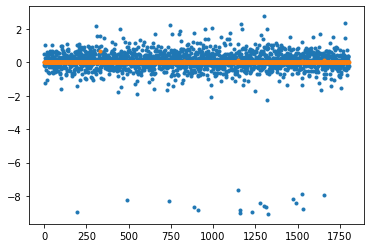

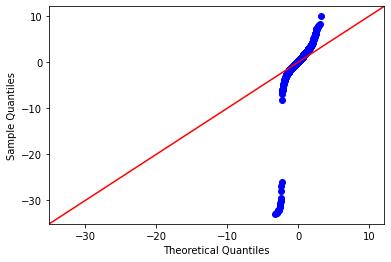

In [9]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

new_train_data = train_data

#Fit linear model
model = sm.OLS(new_train_data["target"],new_train_data[features])
results = model.fit()

#create instance of influence
influence = results.get_influence()

#leverage (hat values)
leverage = influence.hat_matrix_diag

#Cook's D values (and p-values) as tuple of arrays
cooks_d = influence.cooks_distance

#standardized residuals
standardized_residuals = influence.resid_studentized_internal

plt.plot(standardized_residuals ,'.')
plt.plot(cooks_d[0] ,'.')

# qq plot
res = results.resid # residuals
fig = sm.qqplot(res,line='45')

print("Rsq", results.rsquared)
plt.show()


Rsq 0.07707344549966288


/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:693: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


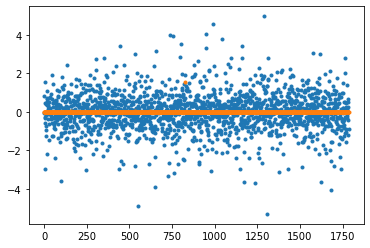

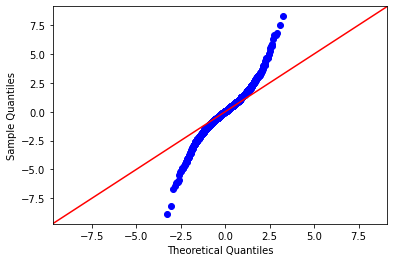

In [10]:
# OLS after removing someoutliers
import matplotlib.pyplot as plt

indexNames = train[ abs(train['target']) > 10].index
train.drop(indexNames , inplace=True)
train_split = np.split(train, [int(0.9*train.shape[0])] , axis=0)
train_data = train_split[0]
test_data = train_split[1]


new_train_data = train_data

#Fit linear model
model = sm.OLS(new_train_data["target"],new_train_data[features])
results = model.fit()

#create instance of influence
influence = results.get_influence()

#leverage (hat values)
leverage = influence.hat_matrix_diag

#Cook's D values (and p-values) as tuple of arrays
cooks_d = influence.cooks_distance

#standardized residuals
standardized_residuals = influence.resid_studentized_internal

plt.plot(standardized_residuals ,'.')
plt.plot(cooks_d[0] ,'.')

# qq plot
res = results.resid # residuals
fig = sm.qqplot(res,line='45')

print("Rsq", results.rsquared)
plt.show()


# Ensemble Learning


Reference: https://www.kaggle.com/fabiendaniel/elo-world#3.-Training-the-model

In [11]:
param = {'num_leaves': 105,
         'min_data_in_leaf': 66, 
         'objective':'regression',
         'max_depth': 8,
         'learning_rate': 0.005,
         "boosting": "gbdt",    #change it to rf for random forrests
         "feature_fraction": 0.733,
         "bagging_freq": 1,
         "bagging_fraction": 0.9597 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 2.251,
         "random_state": 133,
         "verbosity": -1}



from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

folds = KFold(n_splits=5, shuffle=True, random_state=9)

oof = np.zeros(len(train_data))
predictions = np.zeros(len(test_data))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_data.values, train_data["target"].values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_data.iloc[trn_idx][features],
                           label=train_data["target"].iloc[trn_idx],
                             )
    val_data = lgb.Dataset(train_data.iloc[val_idx][features],
                           label=train_data["target"].iloc[val_idx],
                            )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train_data.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_data[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, train_data["target"])**0.5))


fold n°0
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 1.63366	valid_1's rmse: 1.74055
[200]	training's rmse: 1.57889	valid_1's rmse: 1.74287
[300]	training's rmse: 1.53094	valid_1's rmse: 1.7434
Early stopping, best iteration is:
[113]	training's rmse: 1.62607	valid_1's rmse: 1.74031
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 1.66481	valid_1's rmse: 1.61229
[200]	training's rmse: 1.61118	valid_1's rmse: 1.61167
[300]	training's rmse: 1.56366	valid_1's rmse: 1.61198
[400]	training's rmse: 1.52176	valid_1's rmse: 1.61408
Early stopping, best iteration is:
[219]	training's rmse: 1.6019	valid_1's rmse: 1.61125
fold n°2
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 1.65186	valid_1's rmse: 1.67076
[200]	training's rmse: 1.59779	valid_1's rmse: 1.66394
[300]	training's rmse: 1.5515	valid_1's rmse: 1.66173
[400]	training's rmse: 1.50931	valid_1's rmse: 1.66186
[500]

Feature importance visualization
Reference: https://www.kaggle.com/fabiendaniel/elo-world#4.-Feature-importance

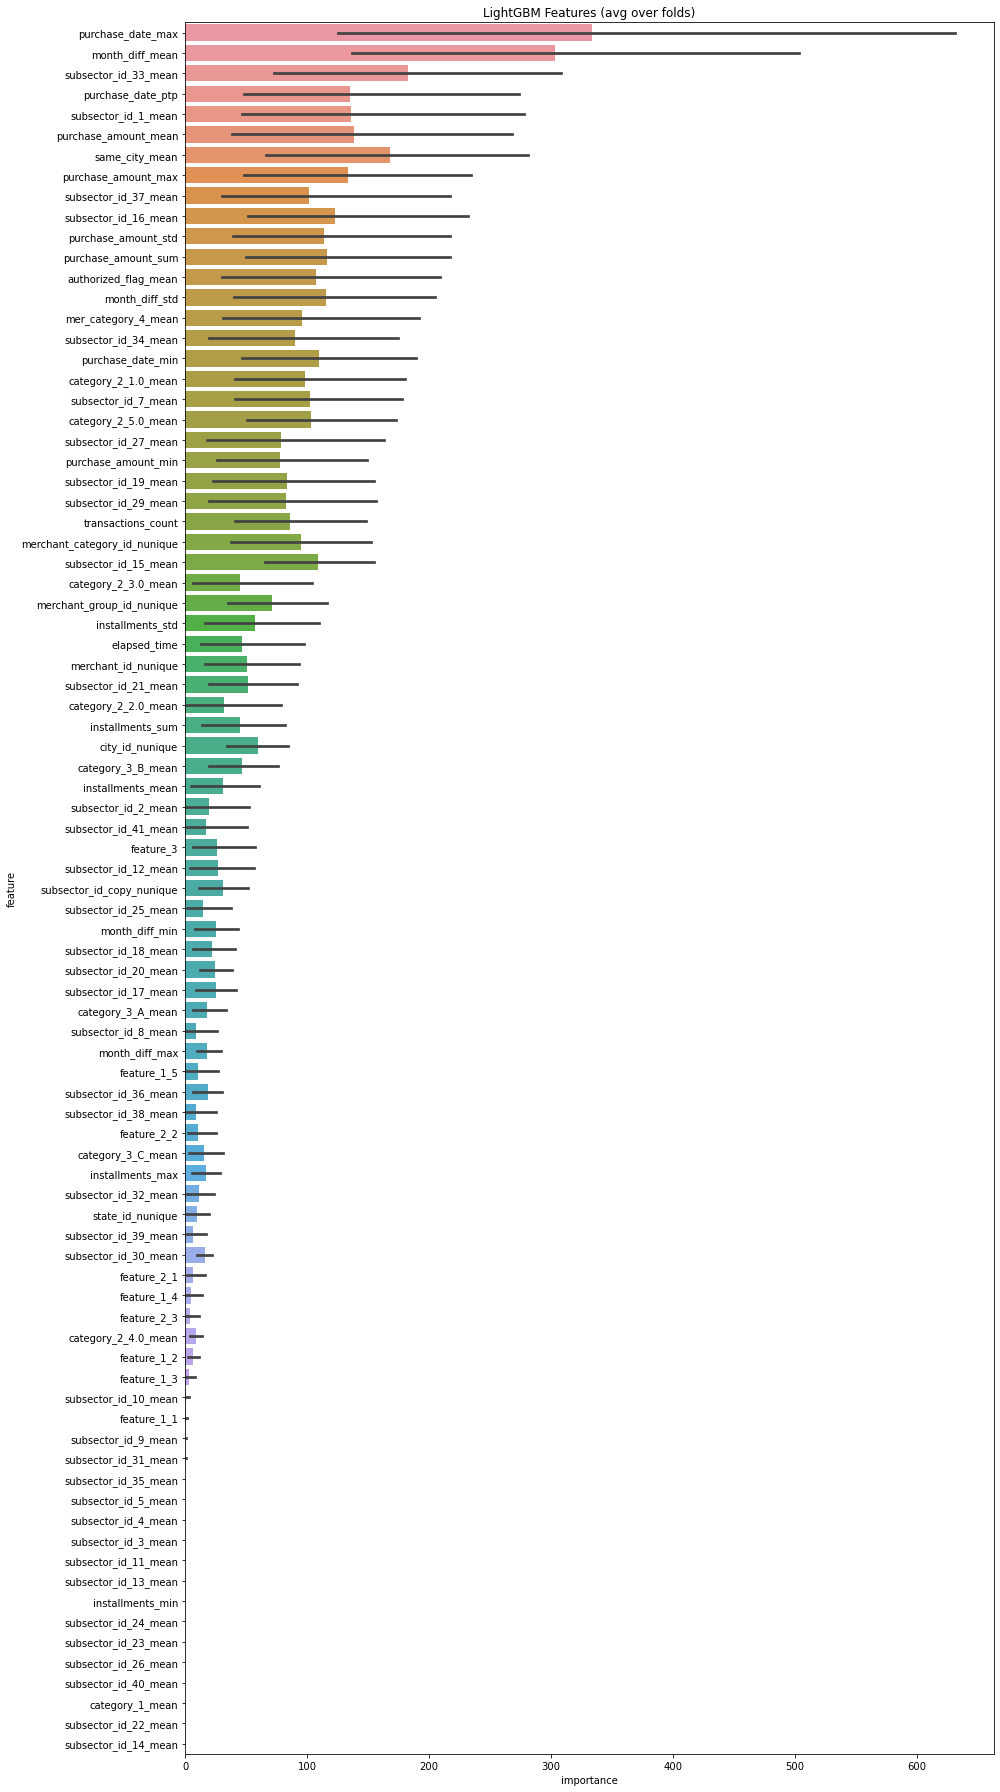

In [12]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

# Bayseian Optimization
Reference : https://www.kaggle.com/fabiendaniel/hyperparameter-tuning

In [13]:

import pandas as pd
from datetime import datetime
import gc
import warnings
from bayes_opt import BayesianOptimization

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from datetime import datetime
warnings.simplefilter(action='ignore', category=FutureWarning)

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod(
            (datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        

def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [14]:
def LGB_CV(
          max_depth,
          num_leaves,
          min_data_in_leaf,
          feature_fraction,
          bagging_fraction,
          lambda_l1
         ):
    
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(train.shape[0])

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                               label=target.iloc[trn_idx],
                               categorical_feature=categorical_feats)
        val_data = lgb.Dataset(train.iloc[val_idx][features],
                               label=target.iloc[val_idx],
                               categorical_feature=categorical_feats)
    
        param = {
            'num_leaves': int(num_leaves),
            'min_data_in_leaf': int(min_data_in_leaf), 
            'objective':'regression',
            'max_depth': int(max_depth),
            'learning_rate': 0.01,
            "boosting": "gbdt",
            "feature_fraction": feature_fraction,
            "bagging_freq": 1,
            "bagging_fraction": bagging_fraction ,
            "bagging_seed": 11,
            "metric": 'rmse',
            "lambda_l1": lambda_l1,
            "verbosity": -1
        }
    
        clf = lgb.train(param,
                        trn_data,
                        10000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds = 200)
        
        oof[val_idx] = clf.predict(train.iloc[val_idx][features],
                                   num_iteration=clf.best_iteration)
        
        del clf, trn_idx, val_idx
        gc.collect()
        
    return -mean_squared_error(oof, target)**0.5

train = pd.read_csv("../input/elodmbiproject/td01_1.csv", index_col=0)
train = reduce_mem_usage(train)

target = train['target']
del train['target']

features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = [c for c in features if 'feature_' in c]

LGB_BO = BayesianOptimization(LGB_CV, {
    'max_depth': (4, 10),
    'num_leaves': (5, 130),
    'min_data_in_leaf': (10, 150),
    'feature_fraction': (0.7, 1.0),
    'bagging_fraction': (0.7, 1.0),
    'lambda_l1': (0, 6)
    })

print('-'*126)

start_time = timer(None)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=2, n_iter=20, acq='ei', xi=0.0)
timer(start_time)

Mem. usage decreased to  0.06 Mb (48.2% reduction)
------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | featur... | lambda_l1 | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------
fold n°0
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47]	training's rmse: 3.73326	valid_1's rmse: 3.70364
fold n°1
Training until validation scores don't improve for 200 rounds
[500]	training's rmse: 3.6288	valid_1's rmse: 4.07871
Early stopping, best iteration is:
[379]	training's rmse: 3.62889	valid_1's rmse: 4.07831
fold n°2
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1]	training's rmse: 3.72429	valid_1's rmse: 3.76567
fold n°3
Training until validation scores don't improve for 200 rounds
Early stopping, best 